本文主要介绍将pytorch模型准确导出为可用的onnx模型。以方便OpenCV Dnn,NCNN,MNN,TensorRT等框架调用。

# 1 使用说明
本文示例为调用pytorch预训练的mobilenetv2模型，将其导出为onnx模型。主要步骤如下：
1. 读取模型
2. 检测图像
3. 导出为onnx模型
4. 模型测试
5. 模型简化

In [1]:
# 需要调用的头文件
import torch
from torchvision import models
import cv2
import numpy as np
from torchsummary import summary
import onnxruntime
from onnxsim import simplify
import onnx
from matplotlib import pyplot as plt

# 判断使用CPU还是GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1.1 读取模型
该部分主要为调用训练好的模型。主要内容如下
1. 直接读取预训练模型
2. 将模型转换为推理模型
3. 查看模型的结构

In [2]:
# ----- 1 读取模型
print("----- 1 读取模型 -----")
# 载入模型并读取权重
model = models.mobilenet_v2(pretrained=True)
# 将模型转换为推理模式
model.eval()
# 查看模型的结构，(3,224,224)为模型的图像输入
summary(model, (3, 224, 224))

----- 1 读取模型 -----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14

## 1.2 检测图像
该部分主要为检测图像，查看模型结果。一般来说pytorch导出的onnx模型都是用于C++调用，所以基于OpenCV直接读取图像，进行图像通道转换以及图像归一化以模拟实际C++调用情况，而不是用pillow和pytorch的transform。一般来说C++提供的图像都是经由OpenCV调用而来。主要内容如下：
1. 基于OpenCV读取图像,进行通道转换
2. 将图像进行归一化
3. 进行模型推理，查看结果

----- 2 检测图像 -----


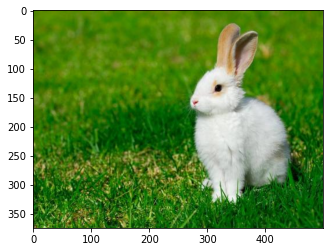

['预测标签为: 331,预测概率为:54.409969329833984;', '预测标签为: 330,预测概率为:33.62083435058594;', '预测标签为: 332,预测概率为:11.84182071685791;', '预测标签为: 263,预测概率为:0.05221949517726898;', '预测标签为: 264,预测概率为:0.027525480836629868;']


In [3]:
# ----- 2 检测图像
print("----- 2 检测图像 -----")
# 待检测图像路径 
img_path = './image/rabbit.jpg'

# 读取图像
img = cv2.imread(img_path)
# 图像通道转换
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 展示图像
plt.imshow(img)
plt.show()
# 图像大小重置为模型输入图像大小
img = cv2.resize(img, (224, 224))

# 图像归一化
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img = np.array((img / 255.0 - mean) / std, dtype=np.float32)

# 图像通道转换
img = img.transpose([2, 0, 1])
# 获得pytorch需要的输入图像格式NCHW
img_ = torch.from_numpy(img).unsqueeze(0)
img_ = img_.to(device)
# 推理
outputs = model(img_)

# 得到预测结果，并且按概率从大到小排序
_, indices = torch.sort(outputs, descending=True)
# 返回top5每个预测标签的百分数
percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print(["预测标签为: {},预测概率为:{};".format(idx, percentage[idx].item()) for idx in indices[0][:5]])

# 保存/载入整个pytorch模型
# torch.save(model, 'model.ckpt')
# model = torch.load('model.ckpt')

# 仅仅保存/载入pytorch模型的参数
# torch.save(model.state_dict(), 'params.ckpt')
# model.load_state_dict(torch.load('params.ckpt'))

## 1.3 导出为onnx模型
该部分主要为导出onnx模型，两行代码就可以搞定,onnx模型导出路径为当前目录下mobilenet_v2.onnx。具体如下：
```python
x = torch.rand(1, 3, 224, 224)
torch_out = torch.onnx._export(model, x, output_name, export_params=True,
                               input_names=["input"], output_names=["output"])
```

In [4]:
# ---- 3 导出为onnx模型
print("----- 3 导出为onnx模型 -----")
# An example input you would normally provide to your model's forward() method
# x为输入图像，格式为pytorch的NCHW格式；1为图像数一般不需要修改；3为通道数；224，224为图像高宽；
x = torch.rand(1, 3, 224, 224)
# 模型输出名
output_name = "mobilenet_v2.onnx"
# Export the model
# 导出为onnx模型
# model为模型，x为模型输入，"mobilenet_v2.onnx"为onnx输出名，export_params表示是否保存模型参数
# input_names为onnx模型输入节点名字，需要输入列表
# output_names为onnx模型输出节点名字，需要输入列表；如果是多输出修改为output_names=["output1","output2"]
torch_out = torch.onnx._export(model, x, output_name, export_params=True,
                               input_names=["input"], output_names=["output"])
print("模型导出成功")

----- 3 导出为onnx模型 -----
模型导出成功


## 1.4 模型测试
该部分主要为测试模型，一般可以跳过，不需要这部分代码，通常模型转换不会出错。另外onnx模型可以通过[Netron](https://github.com/lutzroeder/Netron)查看结构。

In [5]:
# ---- 4 模型测试(可跳过)
print("----- 4 模型测试 -----")


# 可以跳过该步骤，一般不会有问题

# 检查输出
def check_onnx_output(filename, input_data, torch_output):
    session = onnxruntime.InferenceSession(filename)
    input_name = session.get_inputs()[0].name
    result = session.run([], {input_name: input_data.numpy()})
    for test_result, gold_result in zip(result, torch_output.values()):
        np.testing.assert_almost_equal(
            gold_result.cpu().numpy(), test_result, decimal=3,
        )
    return result


# 检查模型
def check_onnx_model(model, onnx_filename, input_image):
    with torch.no_grad():
        torch_out = {"output": model(input_image)}
    check_onnx_output(onnx_filename, input_image, torch_out)
    onnx_model = onnx.load(onnx_filename)
    onnx.checker.check_model(onnx_model)
    print("模型测试成功")
    return onnx_model

# 检测导出的onnx模型是否完整
# 一般出现问题程序直接报错，不过很少出现问题
onnx_model = check_onnx_model(model, output_name, x)

----- 4 模型测试 -----
模型测试成功


## 1.5 模型简化
一般来说导出后的onnx模型会有一堆冗余操作，需要简化。推荐使用[onnx-simplifier](https://github.com/daquexian/onnx-simplifier)进行onnx模型简化。onnx简化模型导出路径为当前目录下mobilenet_v2.onnxsim.onnx
调用onnx-simplifier有三种办法：
1. 调用代码，调用onnx-simplifier的simplify接口
2. 命令行简化，直接输入python3 -m onnxsim input_onnx_model output_onnx_model
3. 在线调用，调用[onnx-simplifier](https://github.com/daquexian/onnx-simplifier)作者的[https://convertmodel.com/](https://convertmodel.com/)直接进行模型简化。

具体来说推荐第三种在线使用，第三种在线调用方便，还能将onnx模型转换为ncnn,mnn等模型格式。

P.S. onnx-simplifier对于高版本pytorch不那么支持，转换可能失败，所以设置skip_fuse_bn=True跳过融合bn层。这种情况下onnx-simplifier转换出来的onnx模型可能比转换前的模型大，原因是补充了shape信息。

In [6]:
# ----- 5 模型简化
print("----- 5 模型简化 -----")
# 基于onnx-simplifier简化模型，https://github.com/daquexian/onnx-simplifier
# 也可以命令行输入python3 -m onnxsim input_onnx_model output_onnx_model
# 或者使用在线网站直接转换https://convertmodel.com/

# 输出模型名
filename = output_name + "sim.onnx"
# 简化模型
# 设置skip_fuse_bn=True表示跳过融合bn层，pytorch高版本融合bn层会出错
simplified_model, check = simplify(onnx_model, skip_fuse_bn=True)
onnx.save_model(simplified_model, filename)
onnx.checker.check_model(simplified_model)
# 如果出错
assert check, "简化模型失败"
print("模型简化成功")

----- 5 模型简化 -----
模型简化成功


## 1.6 全部代码
全部工程代码如下

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec  8 19:44:42 2020

@author: luohenyueji
"""

import torch
from torchvision import models
import cv2
import numpy as np
from torchsummary import summary
import onnxruntime
from onnxsim import simplify
import onnx
from matplotlib import pyplot as plt

# 判断使用CPU还是GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ----- 1 读取模型
print("----- 1 读取模型 -----")
# 载入模型并读取权重
model = models.mobilenet_v2(pretrained=True)
# 将模型转换为推理模式
model.eval()
# 查看模型的结构，(3,224,224)为模型的图像输入
# summary(model, (3, 224, 224))

# ----- 2 检测图像
print("----- 2 检测图像 -----")
# 待检测图像路径 
img_path = './image/rabbit.jpg'

# 读取图像
img = cv2.imread(img_path)
# 图像通道转换
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# 展示图像
# plt.imshow(img)
# plt.show()
# 图像大小重置为模型输入图像大小
img = cv2.resize(img, (224, 224))

# 图像归一化
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img = np.array((img / 255.0 - mean) / std, dtype=np.float32)

# 图像通道转换
img = img.transpose([2, 0, 1])
# 获得pytorch需要的输入图像格式NCHW
img_ = torch.from_numpy(img).unsqueeze(0)
img_ = img_.to(device)
# 推理
outputs = model(img_)

# 得到预测结果，并且按概率从大到小排序
_, indices = torch.sort(outputs, descending=True)
# 返回top5每个预测标签的百分数
percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print(["预测标签为: {},预测概率为:{};".format(idx, percentage[idx].item()) for idx in indices[0][:5]])

# 保存/载入整个pytorch模型
# torch.save(model, 'model.ckpt')
# model = torch.load('model.ckpt')

# 仅仅保存/载入pytorch模型的参数
# torch.save(model.state_dict(), 'params.ckpt')
# model.load_state_dict(torch.load('params.ckpt'))

# ---- 3 导出为onnx模型
print("----- 3 导出为onnx模型 -----")
# An example input you would normally provide to your model's forward() method
# x为输入图像，格式为pytorch的NCHW格式；1为图像数一般不需要修改；3为通道数；224，224为图像高宽；
x = torch.rand(1, 3, 224, 224)
# 模型输出名
output_name = "mobilenet_v2.onnx"
# Export the model
# 导出为onnx模型
# model为模型，x为模型输入，"mobilenet_v2.onnx"为onnx输出名，export_params表示是否保存模型参数
# input_names为onnx模型输入节点名字，需要输入列表
# output_names为onnx模型输出节点名字，需要输入列表；如果是多输出修改为output_names=["output1","output2"]
torch_out = torch.onnx._export(model, x, output_name, export_params=True,
                               input_names=["input"], output_names=["output"])
print("模型导出成功")

# ---- 4 模型测试(可跳过)
print("----- 4 模型测试 -----")


# 可以跳过该步骤，一般不会有问题

# 检查输出
def check_onnx_output(filename, input_data, torch_output):
    session = onnxruntime.InferenceSession(filename)
    input_name = session.get_inputs()[0].name
    result = session.run([], {input_name: input_data.numpy()})
    for test_result, gold_result in zip(result, torch_output.values()):
        np.testing.assert_almost_equal(
            gold_result.cpu().numpy(), test_result, decimal=3,
        )
    return result


# 检查模型
def check_onnx_model(model, onnx_filename, input_image):
    with torch.no_grad():
        torch_out = {"output": model(input_image)}
    check_onnx_output(onnx_filename, input_image, torch_out)
    onnx_model = onnx.load(onnx_filename)
    onnx.checker.check_model(onnx_model)
    print("模型测试成功")
    return onnx_model


# 检测导出的onnx模型是否完整
# 一般出现问题程序直接报错，不过很少出现问题
onnx_model = check_onnx_model(model, output_name, x)

# ----- 5 模型简化
print("----- 5 模型简化 -----")
# 基于onnx-simplifier简化模型，https://github.com/daquexian/onnx-simplifier
# 也可以命令行输入python3 -m onnxsim input_onnx_model output_onnx_model
# 或者使用在线网站直接转换https://convertmodel.com/

# 输出模型名
filename = output_name + "sim.onnx"
# 简化模型
# 设置skip_fuse_bn=True表示跳过融合bn层，pytorch高版本融合bn层会出错
simplified_model, check = simplify(onnx_model, skip_fuse_bn=True)
onnx.save_model(simplified_model, filename)
onnx.checker.check_model(simplified_model)
# 如果出错
assert check, "简化模型失败"
print("模型简化成功")


----- 1 读取模型 -----
----- 2 检测图像 -----
['预测标签为: 331,预测概率为:54.409969329833984;', '预测标签为: 330,预测概率为:33.62083435058594;', '预测标签为: 332,预测概率为:11.84182071685791;', '预测标签为: 263,预测概率为:0.05221949517726898;', '预测标签为: 264,预测概率为:0.027525480836629868;']
----- 3 导出为onnx模型 -----
模型导出成功
----- 4 模型测试 -----
模型测试成功
----- 5 模型简化 -----
模型简化成功


# 2 参考
+ [Netron](https://github.com/lutzroeder/Netron)
+ [use ncnn with pytorch or onnx](https://github.com/Tencent/ncnn/wiki/use-ncnn-with-pytorch-or-onnx)
+ [PyTorch to CoreML model conversion](https://www.learnopencv.com/pytorch-to-coreml-model-conversion/)
+ [onnx-simplifier](https://github.com/daquexian/onnx-simplifier)
+ [https://convertmodel.com/](https://convertmodel.com/)